In [1]:
import gmsh

import sys
%matplotlib inline
import matplotlib.pyplot as plt
from sympy import solve, symbols
from math import pi, sin, cos
import numpy as np

from firedrake import *
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


/home/pierre/src/firedrake/src/firedrake/firedrake/randomfunctiongen.py:358: UserWarning: Found unknown attribute: Falling back to numpy.random.PCG64DXSM, but Firedrake might need to wrap this attribute.
  warnings.warn("Found unknown attribute: Falling back to numpy.random.%s, but Firedrake might need to wrap this attribute." % module_attr)


In [2]:
mesh = Mesh('horn.msh')


In [3]:
V = FunctionSpace(mesh, "CG", 1)


In [4]:
u = TrialFunction(V)
v = TestFunction(V)
f = Function(V)
x, y = SpatialCoordinate(mesh)

In [5]:
# f.interpolate((1+8*pi*pi)*cos(x*pi*2)*cos(y*pi*2))
f.interpolate((0.0000)*cos(x*pi*2)*cos(y*pi*2))
# f.interpolate((0*x**2+y**2))
BCLaplace = DirichletBC(V, 1, [2])

In [6]:
def helmotz(freq):
    c_air = 430
    scale = (freq/c_air)**2
    a = (inner(grad(u), grad(v)) + scale*inner(u, v)) * dx
    g = Constant(2.)
    # L = inner(f, v) * dx + g*v*ds(3)
    L = g*v*ds(3)
    sol = Function(V)
    solve(a == L, sol, bcs=BCLaplace, solver_parameters={'ksp_type': 'cg'})
    return sol

In [7]:
def plot_contour(freq, sol):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.set_aspect('equal')
    colors= tripcolor(sol, axes=ax1)
    # fig.colorbar(colors)
    ax2.set_aspect('equal')
    contours = tricontour(sol, levels=50, axes=ax2)
    # fig.colorbar(contours)
    plt.title('{}Hz'.format(freq))
    plt.show()

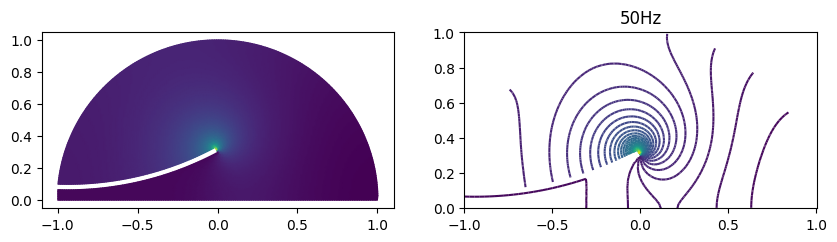

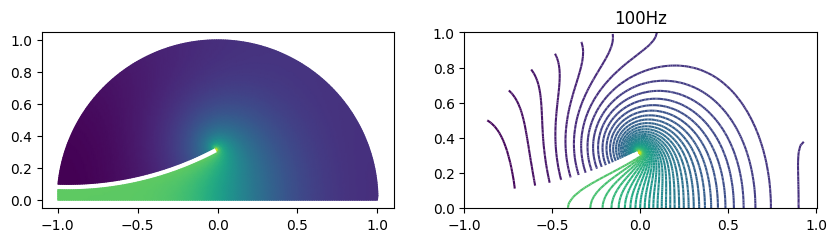

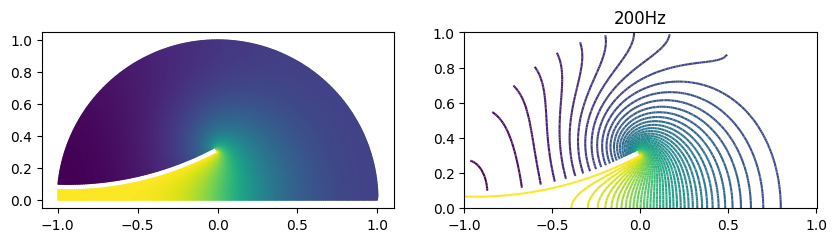

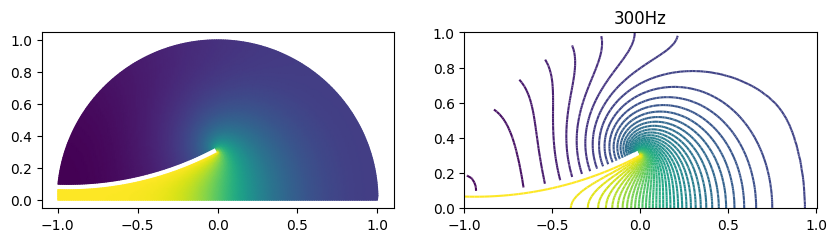

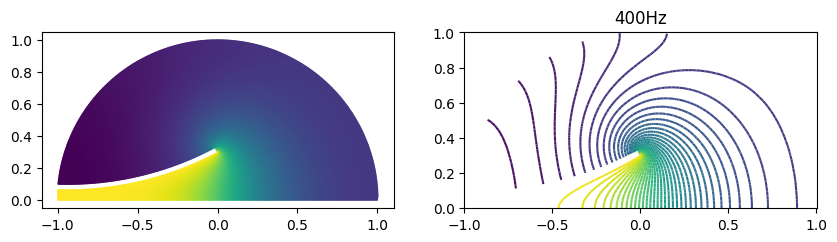

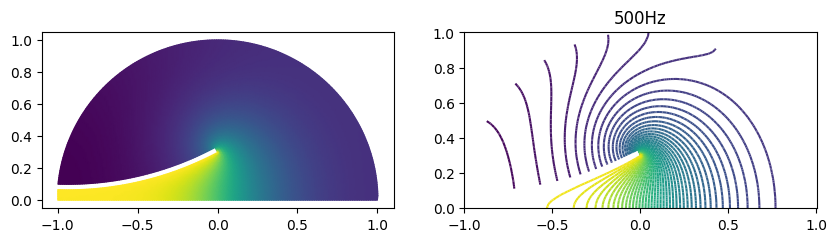

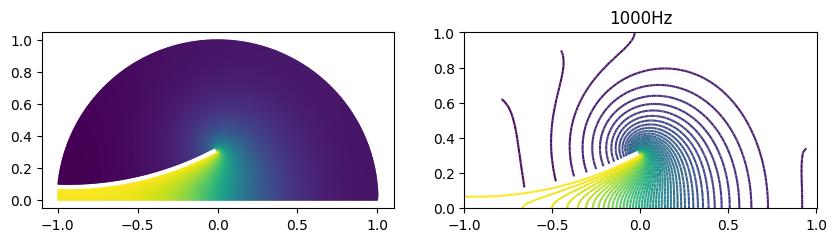

In [8]:
for f in (50, 100, 200, 300, 400, 500, 1000):
    s = helmotz(f)
    plot_contour(f, s)